In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import dask
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:107: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load datasets

In [2]:
ecco = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/')

In [3]:
budgFw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw.nc').budg_fw
budgH = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_heat.nc').budg_heat

In [4]:
dif_ConvFw = budgFw.sel(term='tendFw') - budgFw.sel(term='totalFw')
budgFw = xr.concat([budgFw, dif_ConvFw.assign_coords(term='dif_ConvFw')], dim='term')

In [5]:
flx = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_fw.nc')
nc = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_heat.nc')
flx['heat'] = nc.heat

### Seasonal anomalies

In [6]:
budgH_anom = budgH.groupby('time.month') - budgH.groupby('time.month').mean('time')
budgFw_anom = budgFw.groupby('time.month') - budgFw.groupby('time.month').mean('time')
flx_anom = flx.groupby('time.month') - flx.groupby('time.month').mean('time')

### Integrate anomalies

In [7]:
budgFw_int = (budgFw_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')
budgH_int = (budgH_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')

flx_int = (flx_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')
flx_int['time'] = ecco.time.isel(time=slice(1, -1))

In [8]:
budgFw_int = budgFw_int.sel(time=slice('1993-01-01','2015-12-31'))
budgH_int = budgH_int.sel(time=slice('1993-01-01','2015-12-31'))
flx_int = flx_int.sel(time=slice('1993-01-01','2015-12-31'))

### Anomalies (from the mean)

In [9]:
budgFw_anom = budgFw_int - budgFw_int.mean('time')
budgH_anom = budgH_int - budgH_int.mean('time')
flx_anom = flx_int - flx_int.mean('time')

### Plot

In [10]:
class OffsetYearLocator(dates.YearLocator):
    def __init__(self, *args, **kwargs):
        self.offset = kwargs.pop("offset", 0)
        dates.YearLocator.__init__(self,*args, **kwargs)
    def tick_values(self, vmin, vmax):
        ymin = self.base.le(vmin.year) * self.base.step - self.offset
        ymax = self.base.ge(vmax.year) * self.base.step + (self.base.step-self.offset)
        ticks = [vmin.replace(year=ymin, **self.replaced)]
        while True:
            dt = ticks[-1]
            if dt.year >= ymax:
                return dates.date2num(ticks)
            year = dt.year + self.base.step
            ticks.append(dt.replace(year=year, **self.replaced))

def format_xaxis(ax):

    years = dates.YearLocator(10,month=1,day=1)
    years1=OffsetYearLocator(2,month=1,day=1, offset=1)
    dfmt = dates.DateFormatter('%Y')
    dfmt1 = dates.DateFormatter('%y')

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(years1)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_minor_formatter(dfmt1)
    ax.get_xaxis().set_tick_params(which='major', pad=15)

    plt.setp(ax.get_xmajorticklabels(), rotation=0, weight="bold", ha="center")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


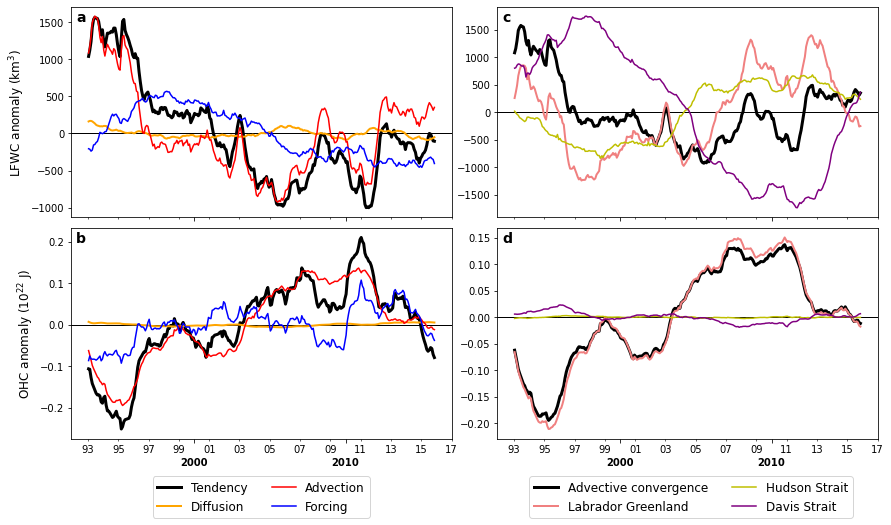

In [11]:
fig, axs = plt.subplots(2, 2,sharex=True, figsize=(14, 8))


axs[0,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='tendFw')*1e-3, 
              lw=3, color='black',label='Tendency')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='dif_ConvFw')*1e-3, 
              lw=2, color='orange',label='Diffusion')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='adv_ConvFw')*1e-3, 
              lw=1.5, color='red',label='Advection')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='forcFw')*1e-3, 
              lw=1.5, color='blue',label='Forcing')
axs[0,0].set_ylabel(r'LFWC anomaly (km$^3$)',fontsize=12)

axs[0,0].text(0.013,0.93, 'a', fontsize=14, fontweight='bold', transform=axs[0,0].transAxes)
#axs[0,0].set_title(r'Labrador Sea', fontsize=12)

axs[1,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='tendH')*1e-22, 
              lw=3, color='black',label='Tendency')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='dif_ConvH')*1e-22, 
              lw=2, color='orange',label='Diffusion')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='adv_ConvH')*1e-22, 
              lw=1.5, color='red',label='Advection')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='forcH')*1e-22, 
              lw=1.5, color='blue',label='Forcing')

axs[1,0].set_ylabel(r'OHC anomaly (10$^{22}$ J)', fontsize=12)
axs[1,0].text(0.013,0.93, 'b', fontsize=14, fontweight='bold', transform=axs[1,0].transAxes)
format_xaxis(axs[1,0])
axs[1,0].legend(frameon=True, fancybox=True, bbox_to_anchor=(0.8, -0.15), ncol=2, fontsize=12)


axs[0,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='adv_ConvFw')*1e-3, lw=3, color='k',
              label='Advective convergence')
axs[0,1].plot(flx_anom.time, flx_anom.sel(section='Labrador Greenland').fw*1e-3, lw=2, color='lightcoral',
              label='Labrador Greenland')
axs[0,1].plot(flx_anom.time, -flx_anom.sel(section='Hudson Strait').fw*1e-3, lw=1.5, color='y',
              label='Hudson Strait')
axs[0,1].plot(flx_anom.time, -flx_anom.sel(section='Davis Strait').fw*1e-3, lw=1.5, color='purple',
              label='Davis Strait')
axs[0,1].text(0.013,0.93, 'c', fontsize=14, fontweight='bold', transform=axs[0,1].transAxes)
#axs[0,1].set_title(r'Labrador Sea', fontsize=12)

axs[1,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='adv_ConvH')*1e-22, lw=3, color='k',
              label='Advective convergence')
axs[1,1].plot(flx_anom.time, flx_anom.sel(section='Labrador Greenland').heat*1e-7, lw=2, color='lightcoral',
              label='Labrador Greenland')
axs[1,1].plot(flx_anom.time, -flx_anom.sel(section='Hudson Strait').heat*1e-7, lw=1.5, color='y',
              label='Hudson Strait')
axs[1,1].plot(flx_anom.time, -flx_anom.sel(section='Davis Strait').heat*1e-7, lw=1.5, color='purple',
              label='Davis Strait')
axs[1,1].text(0.013,0.93, 'd', fontsize=14, fontweight='bold', transform=axs[1,1].transAxes)
format_xaxis(axs[1,1])
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.95, hspace=0.05, wspace=0.12)

axs[1,1].legend(frameon=True, fancybox=True, bbox_to_anchor=(0.95, -0.15), ncol=2, fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()